# Soft Margin Support Vector Machine
___
See the code [here]().

## 1. Libraries

In [61]:
import os
import sys


# Adding the path to the algorithms modules
ROOT_PATH = os.path.join("..", "..", "algos", "basic")
sys.path.append(ROOT_PATH)

import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from svm import SupportVectorMachine

## 2. Dataset

### 2.1. Generating the dataset

In [62]:
# Creating a mock dataset.
X, y = make_blobs(
    n_samples=150, centers=[(-2, -2), (0, 0)], cluster_std=0.5
)

# Setting all 0s to 1s, since that's expected by the binary SVM algorithm.
y[y == 0] = -1

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (150, 2)
y shape: (150,)


### 2.2. Plotting the dataset

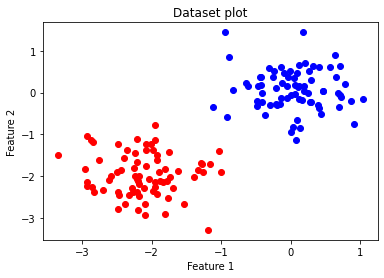

In [63]:
def plot_dataset(X, y, colors={-1: "red", 1: "blue"}, title="Dataset"):
    # Plot the two classes
    for i in range(len(y)):
        plt.scatter(X[i, 0], X[i, 1], color=colors[y[i]])

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


plot_dataset(X, y, title="Dataset plot")

## 3. Training and evaluation

### 3.1. Training

The idea behind the standard (binary) SVM is to find a decision boundary between two different classes. Then, based on this boundary, we can differentiate them.

The implemented SVM here is a **Soft Margin** one, which simply means that it **doesn't expect the dataset to be perfectly linearly separable**, i.e. the cluster of one class can sometimes have samples of the other one, which is expected in real life cases.

#### 3.1.1. Hard Margin SVM
Firstly, we will look at the more primitive way of solving this problem. It is called the *Hard Margin* SVM. Let's start by defining the *feature matrix* $X \in \mathbb{R}^{m \times n}$, the ground truth vector $\textbf{y} \in \mathbb{R}^{m \times 1}$ and the weights vector $\textbf{w} \in \mathbb{R}^{n \times 1}$.

As we know every hyperplane can be described as the set of points $\textbf{x}_i \in \mathbb{R}^{n}$ that satisfy the equation $\textbf{w}^{\intercal}\textbf{x} - b = 0$, where $\textbf{w}$ is the normal vector to the hyperplane.
Instead of using a separate vector for the bias $\textbf{b}$, we will change the structure of $X$ and $\textbf{w}$:
$$ X = concat \left( X, \textbf{1} \right) = concat \left(
    \left[ {\begin{array}{cc}
      x_{11} & \dots & x_{1n}\\
      \vdots & \ddots & \vdots \\
      x_{m1} & \dots & x_{mn}\\
    \end{array} } 
    \right], 
    \left[
      \begin{array}{cc}
      1 \\ \vdots \\ 1
      \end{array}
    \right]
  \right) = \left[ {\begin{array}{cc}
      x_{11} & \dots & x_{1n} & 1 \\
      \vdots & \ddots & \vdots & \vdots \\
      x_{m1} & \dots & x_{mn} & 1 \\
    \end{array} } 
    \right]
$$

and since the shape of $\textbf{w}$ depends on the dimensions of $X$, $\textbf{w} \in \mathbb{R}^{n + 1 \times 1} $, it's $n + 1$ because we've added a new column vector to $X$. 

After the changes above, the hyperplane equation is $\textbf{w}^\intercal \textbf{x} = 0$.
Similarly, we can define two other hyperplanes:
- $\textbf{w}^\intercal \textbf{x} = 1$ - anything on or above this hyperplane is classified as 1
- $\textbf{w}^\intercal \textbf{x} = -1$ - anything on or above this hyperplane is classified as -1

The region bounded by these two hyperplanes is called the **margin**. Its size is $\frac{2}{||\textbf{w}||}$, where $||\textbf{w}||$ is the L2 norm of $\textbf{w}$.
A great overall explanation and derivation can be found in this [MIT lecture](https://www.youtube.com/watch?v=_PwhiWxHK8o).

After we've found out what the margin is, we realize that our objective is to maximize $\frac{2}{||\textbf{w}||}$, which is equal to minimizing $||\textbf{w}||$. To prevent data points from falling into the margin, we add these constrains:
- $\textbf{w}^\intercal \textbf{x} \ge 1$, when $y_i = 1$
- $\textbf{w}^\intercal \textbf{x} \le -1$, when $y_i = -1$

These constraints can be merge into one:
$$ y_i(\textbf{w}^\intercal\textbf{x}_i) \ge 1 $$
which in matrix-vector form is:
$$ \textbf{y}\left( X\textbf{w} \right) \ge 1 $$

Then, the *Hard Margin* optimization problem can be concisely written as:
$$ \min_{\textbf{w}} \quad ||\textbf{w}|| $$
$$ \textrm{subject to} \quad \textbf{y}\left( X\textbf{w} \right) \ge 1 $$

#### 3.1.2. Soft Margin SVM
Since the data in the real world is rarely perfectly linearly separable, the *Hinge Loss function* $hl$ is introduced:
$$ hl(x) = \max(0,1 - x) $$
Maybe the best intuitive explanation that I've found about why we use $hl$ is [this video](https://www.youtube.com/watch?v=IjSfa7Q8ngs).

If the *Hard Margin* equation is transformed into its *Soft Margin* form (using the *Hinge Loss*), we arrive at this minimization problem:
$$ \min_{\textbf{w}} \quad \frac{1}{m}hl\left(\textbf{y}\left( X\textbf{w} \right) \right) + \lambda||\textbf{w}||^2 $$
where $\lambda$ is a positive number that allows us to tune how much we care about maximizing the margin $\frac{2}{||\textbf{w}||}$, with respect to minimizing the error $\frac{1}{m}hl\left(\textbf{y}\left( X\textbf{w} \right) \right)$.

The function that should be minimized is used in the [code](https://github.com/auhide/ml-basics-pytorch/blob/main/algos/basic/svm.py), in the method `fit()`.

#### 3.1.3. Useful Resources
1. [Support vector machine, Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine)
2. [MIT 6.034, Learning: Support Vector Machines, Patrick Winston](https://www.youtube.com/watch?v=_PwhiWxHK8o)
3. [Soft Margin SVM: Data Science Concepts, ritvikmath](https://www.youtube.com/watch?v=IjSfa7Q8ngs)

In [64]:
X, y = torch.Tensor(X), torch.Tensor(y).unsqueeze(-1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

print("Starting the training...")
print("Printing the loss for each 20 epochs.")
svm = SupportVectorMachine()
svm.fit(X_train, y_train, iters=20, lambda_=5)

Starting the training...
Printing the loss for each 20 epochs.
Loss: 9.45


### 3.2. Model Evaluation

In [65]:
eval_loss = svm.evaluate(X_valid, y_valid)
print(f"Evaluation loss: {eval_loss:.2f}")

Evaluation loss: 1.84


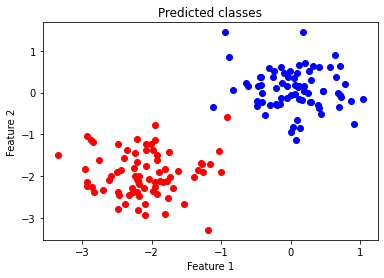

In [66]:
y_pred = svm.predict(X).squeeze(-1).detach().numpy()
y_pred[y_pred >= 0] = 1
y_pred[y_pred < 0] = -1

plot_dataset(X, y_pred.round(), title="Predicted classes")